Saving day.csv to day.csv

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
None

Summary Statistics:
          instant      sea

/tmp/ipython-input-1852391573.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


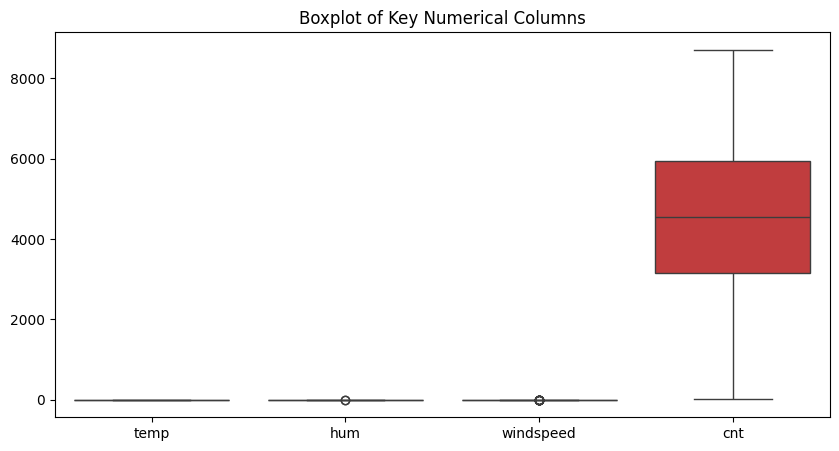


Added human-readable temperature columns.


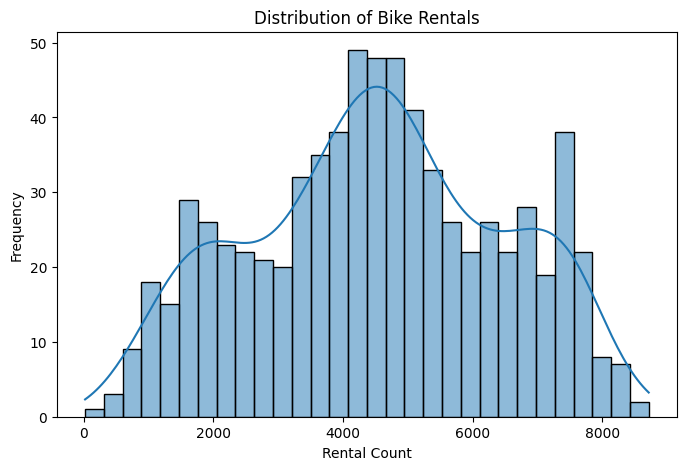

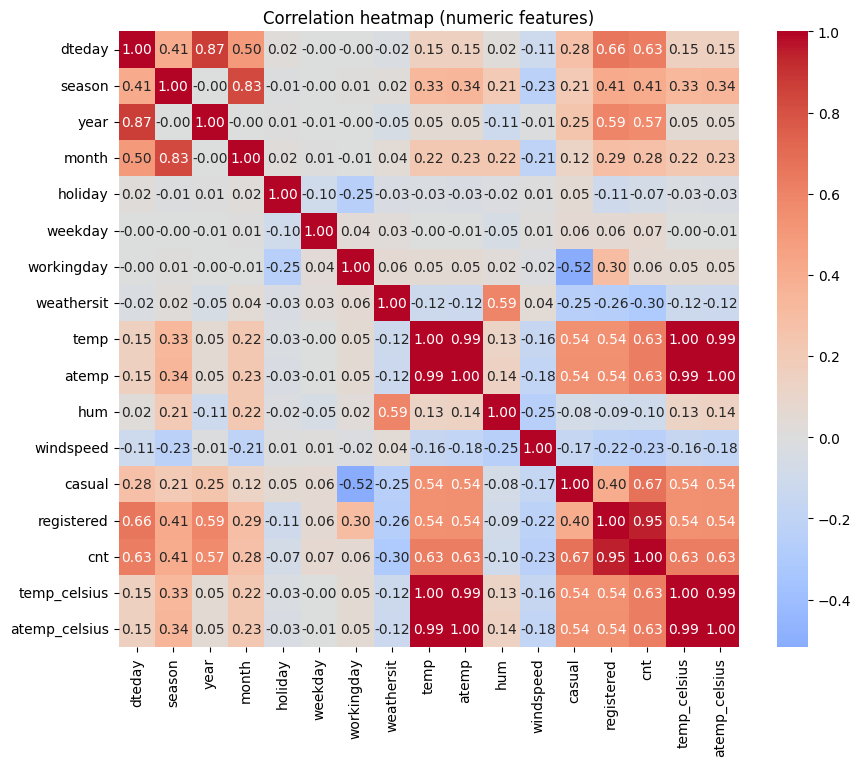

/tmp/ipython-input-1852391573.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='cnt', data=df, palette='Set2')


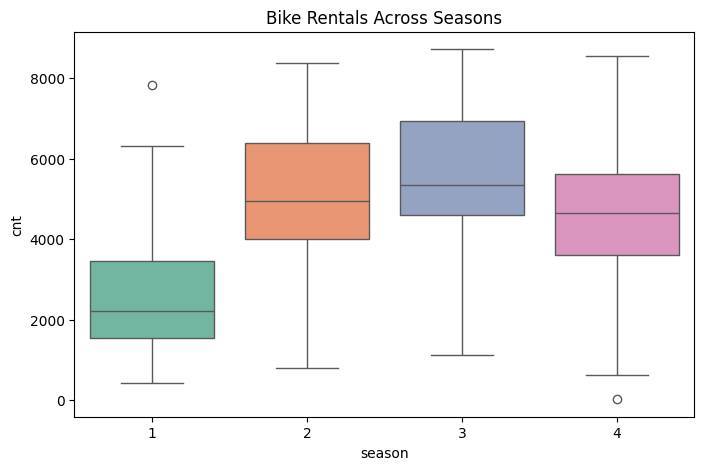

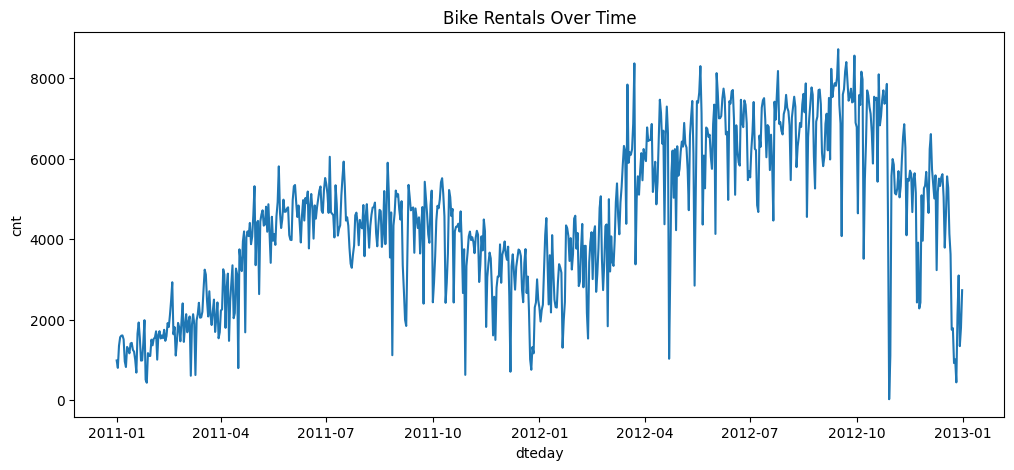



==================== PART 1: Random Forest Regression ====================

Random Forest Regression Metrics:
 MAE : 525.838
 RMSE: 711.411
 R2  : 0.8517


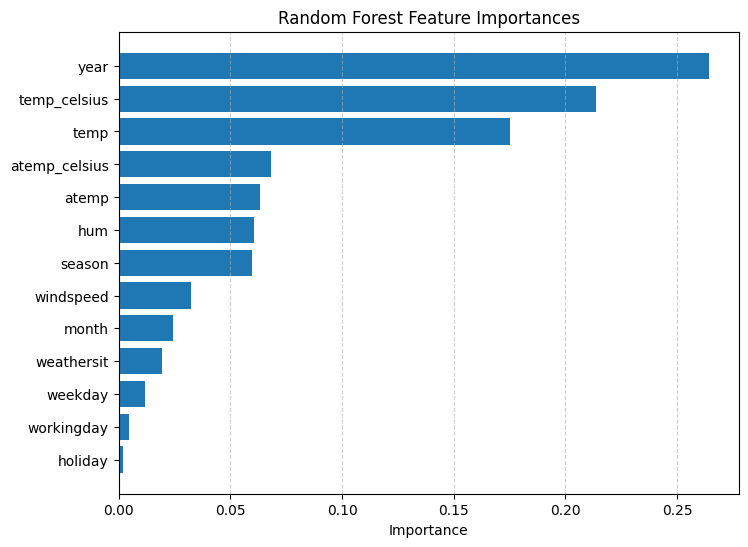

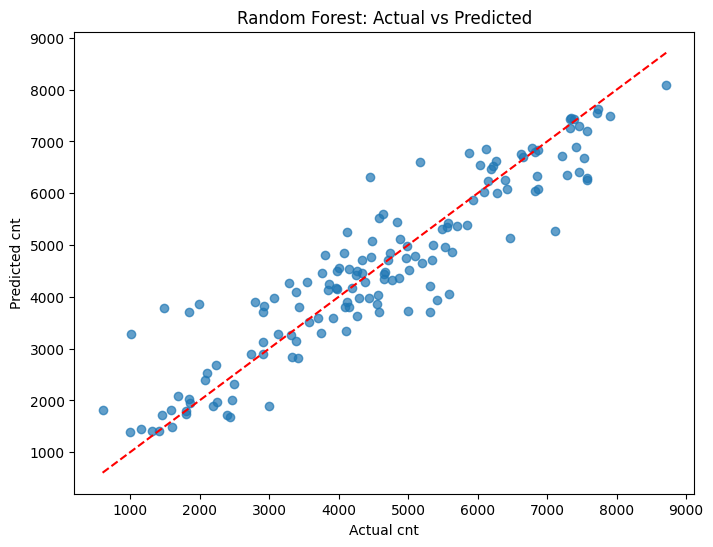

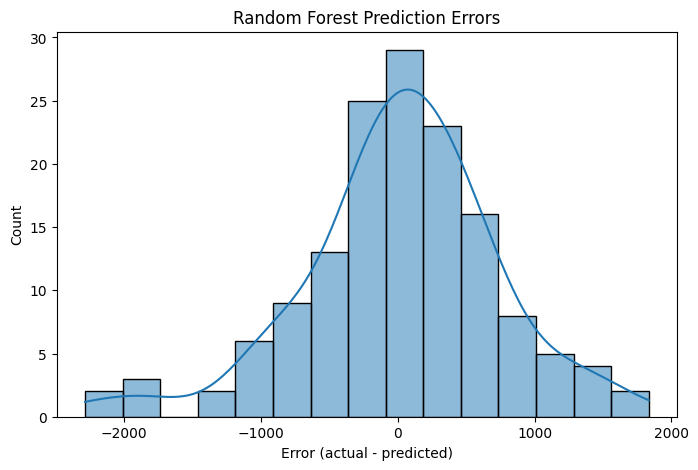



==================== PART 2: Neural Network Regression (MLPRegressor) ====================

MLPRegressor Metrics:
 MAE : 959.643
 RMSE: 1230.695
 R2  : 0.5561


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


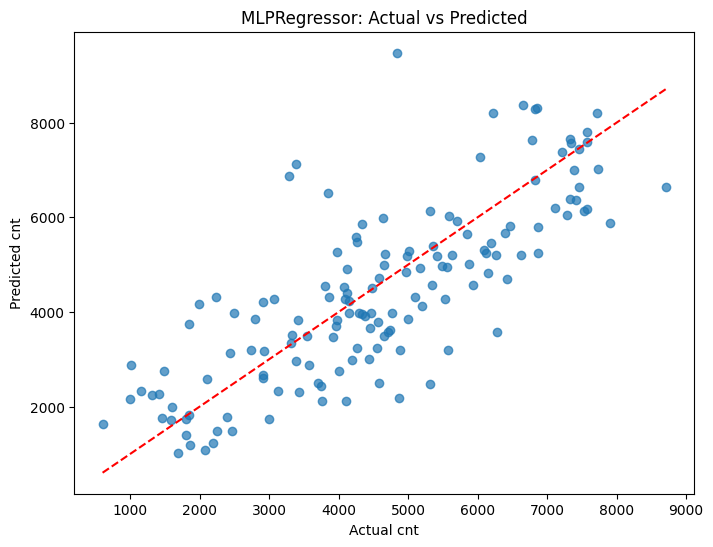

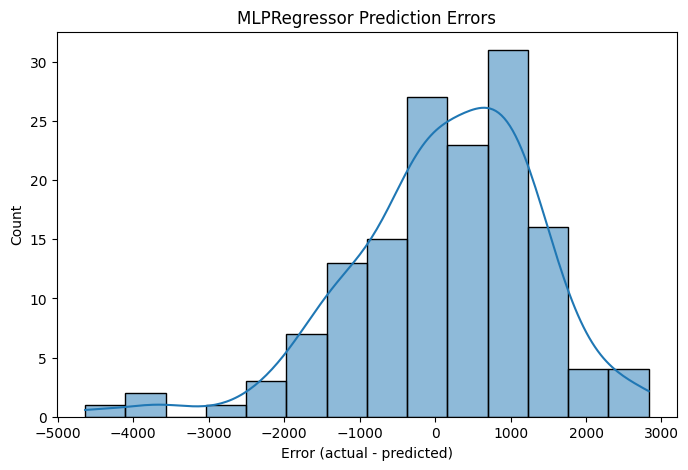



 Random Forest and Neural Network Regression Completed Successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ML imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler


# ============================================================
#                STEP 1: LOAD day.csv FILE
# ============================================================
# User uploads the dataset from computer
uploaded = files.upload()

# Read the CSV file into a DataFrame
df = pd.read_csv("day.csv")

print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nDataset Shape:", df.shape)

# ============================================================
#              STEP 2: BASIC DATA CLEANING
# ============================================================
# 1. Remove duplicate rows
duplicate_count = df.duplicated().sum()
print("\nDuplicate Rows:", duplicate_count)
if duplicate_count > 0:
    df = df.drop_duplicates()

# 2. Handle missing values using forward-fill
df = df.fillna(method='ffill')
print("\nMissing Values After Cleaning:")
print(df.isnull().sum())

# 3. Convert date column from string to datetime
df['dteday'] = pd.to_datetime(df['dteday'])

# 4. Drop irrelevant column "instant" if present
if 'instant' in df.columns:
    df.drop(columns=['instant'], inplace=True)

# 5. Rename columns for readability
df.rename(columns={'mnth': 'month', 'yr': 'year'}, inplace=True)

print("\nData Cleaning Completed.")


# ============================================================
#                 STEP 3: BASIC DATA EXPLORATION
# ============================================================
# Look at skewness and kurtosis of numeric features
print("\nSkewness:")
print(df.skew(numeric_only=True))

print("\nKurtosis:")
print(df.kurt(numeric_only=True))

# Boxplot to visually inspect outliers
plt.figure(figsize=(10,5))
sns.boxplot(data=df[['temp', 'hum', 'windspeed', 'cnt']])
plt.title("Boxplot of Key Numerical Columns")
plt.show()


# ============================================================
#     STEP 4: SIMPLE NON-MODELING TRANSFORMATIONS (EDA USE ONLY)
# ============================================================
# Convert normalized temperature values into °C for human readability
df['temp_celsius'] = df['temp'] * 41
df['atemp_celsius'] = df['atemp'] * 50

print("\nAdded human-readable temperature columns.")


# ============================================================
#           STEP 5: BASIC VISUALIZATIONS (EDA)
# ============================================================

# 1. Distribution of rentals
plt.figure(figsize=(8,5))
sns.histplot(df['cnt'], kde=True, bins=30)
plt.title("Distribution of Bike Rentals")
plt.xlabel("Rental Count")
plt.ylabel("Frequency")
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.show()

# 3. Rentals by season
plt.figure(figsize=(8,5))
sns.boxplot(x='season', y='cnt', data=df, palette='Set2')
plt.title("Bike Rentals Across Seasons")
plt.show()

# 4. Trend of rentals over time
plt.figure(figsize=(12,5))
sns.lineplot(x='dteday', y='cnt', data=df)
plt.title("Bike Rentals Over Time")
plt.show()

# ============================================================
#         PART 1: RANDOM FOREST REGRESSION MODEL
# ============================================================

print("\n\n==================== PART 1: Random Forest Regression ====================")

# Select numeric features only for modeling
numeric_df = df.select_dtypes(include=[np.number]).copy()

# Remove leakage columns BEFORE modeling
# 'casual' and 'registered' are removed because they directly sum to form 'cnt'.
# Including them would cause target leakage and inflate model accuracy.
leakage_cols = ['casual', 'registered']

numeric_df = numeric_df.drop(columns=leakage_cols)

# X = input features, y = target
X = numeric_df.drop(columns=['cnt'])
y = numeric_df['cnt'].astype(float)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

# Build Random Forest Model
rf = RandomForestRegressor(n_estimators=200, random_state=123, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict on test data
rf_pred = rf.predict(X_test)

# Evaluate performance
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("\nRandom Forest Regression Metrics:")
print(f" MAE : {rf_mae:.3f}")
print(f" RMSE: {rf_rmse:.3f}")
print(f" R2  : {rf_r2:.4f}")

# Feature Importance plot
importances = rf.feature_importances_
feat_names = X.columns
idx = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(feat_names[idx], importances[idx])
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.show()

# Actual vs Predicted scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, rf_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual cnt")
plt.ylabel("Predicted cnt")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

# Prediction error distribution
errors = y_test - rf_pred
plt.figure(figsize=(8,5))
sns.histplot(errors, kde=True)
plt.title("Random Forest Prediction Errors")
plt.xlabel("Error (actual - predicted)")
plt.show()


# ============================================================
#     PART 2: NEURAL NETWORK REGRESSION (MLPRegressor)
# ============================================================

print("\n\n==================== PART 2: Neural Network Regression (MLPRegressor) ====================")

# Scale features for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build MLPRegressor model
mlp = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=123)
mlp.fit(X_train_scaled, y_train)

# Predict
mlp_pred = mlp.predict(X_test_scaled)

# Evaluate
mlp_mse = mean_squared_error(y_test, mlp_pred)
mlp_rmse = np.sqrt(mlp_mse)
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_r2 = r2_score(y_test, mlp_pred)

print("\nMLPRegressor Metrics:")
print(f" MAE : {mlp_mae:.3f}")
print(f" RMSE: {mlp_rmse:.3f}")
print(f" R2  : {mlp_r2:.4f}")

# Actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, mlp_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual cnt")
plt.ylabel("Predicted cnt")
plt.title("MLPRegressor: Actual vs Predicted")
plt.show()

# Error distribution
errors_mlp = y_test - mlp_pred
plt.figure(figsize=(8,5))
sns.histplot(errors_mlp, kde=True)
plt.title("MLPRegressor Prediction Errors")
plt.xlabel("Error (actual - predicted)")
plt.show()

print("\n\n Random Forest and Neural Network Regression Completed Successfully!")
